In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from tqdm import tqdm
import cv2

from model import Yolo
from loss import YoloLoss
import os

In [2]:
# pip install os

In [3]:
from PIL import Image

# Open the image file
with Image.open('sample/data/000000.png') as img:
    # Get the width and height of the image
    Image_Width, Image_Height = img.size
    print(f"Image size: {Image_Width} x {Image_Height}")


#kitti dataset의 실제크기, resize를 위해 파악

Image size: 1242 x 375


In [4]:

torch.cuda.is_available() 
print(torch.cuda.device_count())

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

1


'cuda'

### 라벨 전처리

In [5]:
# [class],[Pc = confidence score],[x], [y], [w], [h],[distance] = 0~7 c x y w h dist


In [6]:
# column_names=['class','truncated','occluded','alpha','x1','y1','x2','y2','dimensions_h','dimensions_w','dimensions_len','location_x','location_y','distance','rotation_y']
# one_hot_labeling={'Car':0, 'Van':1, 'Truck':2,'Pedestrian':3, 'Person_sitting':4, 'Cyclist':5, 'Tram':6,'Misc':7, 'DontCare':7}        #Misc and DontCare is same value


# import os

# folder_path = "dataset/training/label_2"

# #txt파일 단위로 불러옴
# for filename in tqdm(os.listdir(folder_path)):
#     temp=pd.read_csv(folder_path+'/'+filename,delimiter=' ',names=column_names)
#     temp=temp.drop(columns=['truncated','occluded','alpha','dimensions_h','dimensions_w','dimensions_len','location_x','location_y','rotation_y'])

#     #class one hot vector로 변환
#     temp['class'] = np.array(list(map(lambda x:one_hot_labeling[x],list(temp['class'])))).reshape(-1, 1)

 

#     temp

#     # 좌표 resize 416* 416
#     temp['x1'] = ((416.0/Image_Width)*temp['x1'])
#     temp['y1'] = ((416.0/Image_Height)*temp['y1'])
#     temp['x2'] = ((416.0/Image_Width)*temp['x2'])
#     temp['y2'] = ((416.0/Image_Height)*temp['y2'])

#     # x y w h 형식으로 bbox 변환 (여기서 x y는 중심좌표,)   
#     center_x=(temp['x1'] + temp['x2'])/2.0
#     center_y=(temp['y1'] + temp['y2'])/2.0
#     w=temp['x2'] - temp['x1']
#     h=temp['y2'] - temp['y1']
#     temp['x1'] = center_x
#     temp['y1'] = center_y
#     temp['x2'] = w
#     temp['y2'] = h

#     temp.rename(columns = {'x1' : 'x','y1' : 'y','x2' : 'w','y2' : 'h'}, inplace = True)

#     #txt형태로 파일 덮어쓰기 
#     temp.to_csv(folder_path+'/'+filename,sep=' ',index = False , header=None)


# # # #이후 데이터셋에서 텐서로 바꿀때 index 8에 c score 자리 만들기


In [7]:
int(416/32)


13

### custom dataset

In [8]:
class CustomDataset(torch.utils.data.Dataset):
    # S= grid cell, B= num of anchors, C = num of classes
    def __init__(self, folder_dir, img_dir, label_dir, S=13, B=5, C=8, transform=None):         
        self.img_folder=folder_dir[0]
        self.label_folder=folder_dir[1]
        self.img_path=img_dir
        self.label_path=label_dir
        
        self.S=S
        self.B=B
        self.C=C
        self.transform=transform
        
    def __len__(self):
        return len(self.img_path)
        

    def __getitem__(self, idx):
        
        #image 전처리
        
        image_filepath = self.img_folder+self.img_path[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (416, 416))
        image=image.transpose(2,0,1)
        image=torch.from_numpy(image).float().div(255.0)
        image.requires_grad=True
        #label 추가 전처리

        bboxes=np.loadtxt(self.label_folder+self.label_path[idx]).tolist()

        label_matrix = torch.zeros((self.S, self.S, self.C+6 )) # 13*13*14(class(8) + c_score x y w h distance)
        
        try:
            for bbox in bboxes:
                # print(bbox)
                class_label=int(bbox[0]) 
                x, y=bbox[1],bbox[2]
                width, height= bbox[3],bbox[4]
                distance= bbox[5]

                # x, y의 위치 grid cell 파악하기
                x_cell = int(x/32) # 0~12
                y_cell = int(y/32) # 0~12
                x_val_inCell = float((x - x_cell * 32.0)/32.0) # 0.0 ~ 1.0
                y_val_inCell = float((y - y_cell * 32.0)/32.0) # 0.0 ~ 1.0

                # w, h 를 0~1 사이의 값으로 만들기
                w = width / 416.0
                h = height / 416.0



                label_matrix[y_cell, x_cell, 8] = 1.0                                       #c_score 8 in pred
                label_matrix[y_cell, x_cell, class_label] = 1.0     #idx 0~7
                label_matrix[y_cell, x_cell, 9] = x_val_inCell                              #bbox 9~12
                label_matrix[y_cell, x_cell, 10] = y_val_inCell
                label_matrix[y_cell, x_cell, 11] = w
                label_matrix[y_cell, x_cell, 12] = h
                label_matrix[y_cell, x_cell, 13] = distance                                 #distance 13
                
                
        # single label
        except TypeError as e:
  
            bbox=bboxes
            class_label=int(bbox[0])
            x, y=bbox[1],bbox[2]
            width, height= bbox[3],bbox[4]
            distance= bbox[5]

            # x, y의 위치 grid cell 파악하기
            x_cell = int(x/32) # 0~12
            y_cell = int(y/32) # 0~12
            x_val_inCell = float((x - x_cell * 32.0)/32.0) # 0.0 ~ 1.0
            y_val_inCell = float((y - y_cell * 32.0)/32.0) # 0.0 ~ 1.0

            # w, h 를 0~1 사이의 값으로 만들기
            w = width / 416.0
            h = height / 416.0

            label_matrix[y_cell, x_cell, 8] = 1.0                                       #c_score 8
            label_matrix[y_cell, x_cell, class_label] = 1.0     #idx 0~7
            label_matrix[y_cell, x_cell, 9] = x_val_inCell                              #bbox 9~12
            label_matrix[y_cell, x_cell, 10] = y_val_inCell
            label_matrix[y_cell, x_cell, 11] = w
            label_matrix[y_cell, x_cell, 12] = h
            label_matrix[y_cell, x_cell, 13] = distance                                 #distance 13
         
        return image.to(device), label_matrix.to(device)

In [9]:
img_label_folder_path=['dataset/data_object_image_2/training/image_2/','dataset/training/label_2/']
img_path=os.listdir('dataset/data_object_image_2/training/image_2/')
label_path=os.listdir('dataset/training/label_2/')


img_path=img_path[0:100]
label_path=label_path[:100]


dset=CustomDataset(img_label_folder_path,img_path,label_path)

In [10]:
img_path

['000000.png',
 '000001.png',
 '000002.png',
 '000003.png',
 '000004.png',
 '000005.png',
 '000006.png',
 '000007.png',
 '000008.png',
 '000009.png',
 '000010.png',
 '000011.png',
 '000012.png',
 '000013.png',
 '000014.png',
 '000015.png',
 '000016.png',
 '000017.png',
 '000018.png',
 '000019.png',
 '000020.png',
 '000021.png',
 '000022.png',
 '000023.png',
 '000024.png',
 '000025.png',
 '000026.png',
 '000027.png',
 '000028.png',
 '000029.png',
 '000030.png',
 '000031.png',
 '000032.png',
 '000033.png',
 '000034.png',
 '000035.png',
 '000036.png',
 '000037.png',
 '000038.png',
 '000039.png',
 '000040.png',
 '000041.png',
 '000042.png',
 '000043.png',
 '000044.png',
 '000045.png',
 '000046.png',
 '000047.png',
 '000048.png',
 '000049.png',
 '000050.png',
 '000051.png',
 '000052.png',
 '000053.png',
 '000054.png',
 '000055.png',
 '000056.png',
 '000057.png',
 '000058.png',
 '000059.png',
 '000060.png',
 '000061.png',
 '000062.png',
 '000063.png',
 '000064.png',
 '000065.png',
 '000066.p

In [11]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dset, batch_size=4, shuffle=True)

In [12]:

# for batch_idx, samples in tqdm(enumerate(dataloader)):
#     _,l=samples
#     # print(l[-1][0])
#     break

torch.Size([4, 13, 13, 14])
torch.Size([416, 416, 3])


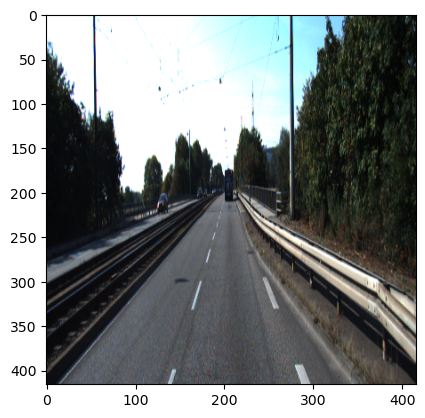

In [13]:
import matplotlib.pyplot as plt

for batch_idx, (inputs, labels) in enumerate(dataloader):
    print(labels.shape)

    inputs= inputs[0]
    inputs.to(device)
    inputs = inputs.permute(1,2,0)
    print(inputs.shape)
    plt.figure()
    plt.imshow(inputs.cpu().detach().numpy())
    plt.show()
    break

### model training

In [14]:
model = Yolo(8).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001) 
criterion=YoloLoss()


In [15]:
model = Yolo(8).to(device)
model.load_state_dict(torch.load('saved_model_15+15epoch'))
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001) 
criterion=YoloLoss()

In [16]:
# criterion(prediction, y_train)

In [17]:
loss_lst=[]
lt = len(dset)

In [34]:
nb_epochs = 15
for epoch in range(nb_epochs + 1):
  model.train()
  total_loss=0
  for batch_idx, samples in (enumerate(dataloader)):
    # print(batch_idx)
    # print(samples)
    x_train, y_train = samples
    # H(x) 계산
    prediction = model(x_train)
    # cost 계산
    # cost,localization_loss,confidence_loss,classification_loss,distance_regression_loss = criterion(prediction, y_train)
    
    cost = criterion(prediction, y_train)
    
    # # cost로 H(x) 계산
    optimizer.zero_grad()
    cost.mean().backward()
    
    optimizer.step()
  
    # print(cost)
    print('Epoch {:4d}/{} Batch {}/{} total loss: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),
        cost.mean()
        ))
    total_loss+=cost.mean()
  loss_lst.append(total_loss/lt)

  print('==================================,',epoch)
  if (epoch+1)%3==0:
    torch.save(model.state_dict(), f'new_saved_model_{epoch+1}epoch')
  

Epoch    0/15 Batch 1/25 total loss: 20548.705078
Epoch    0/15 Batch 2/25 total loss: 31323.583984
Epoch    0/15 Batch 3/25 total loss: 12643.312500
Epoch    0/15 Batch 4/25 total loss: 14689.678711
Epoch    0/15 Batch 5/25 total loss: 1695.989502
Epoch    0/15 Batch 6/25 total loss: 39279.996094
Epoch    0/15 Batch 7/25 total loss: 11493.194336
Epoch    0/15 Batch 8/25 total loss: 7748.847168
Epoch    0/15 Batch 9/25 total loss: 8208.992188
Epoch    0/15 Batch 10/25 total loss: 16127.606445
Epoch    0/15 Batch 11/25 total loss: 29369.486328
Epoch    0/15 Batch 12/25 total loss: 3278.768799
Epoch    0/15 Batch 13/25 total loss: 12772.192383
Epoch    0/15 Batch 14/25 total loss: 16050.026367
Epoch    0/15 Batch 15/25 total loss: 4749.850098
Epoch    0/15 Batch 16/25 total loss: 65497.523438
Epoch    0/15 Batch 17/25 total loss: 33612.242188
Epoch    0/15 Batch 18/25 total loss: 12117.884766
Epoch    0/15 Batch 19/25 total loss: 56438.390625
Epoch    0/15 Batch 20/25 total loss: 2195.84

In [35]:
torch.save(model.state_dict(), 'saved_model_15+15+15+15epoch')

In [36]:
print(loss_lst)

[tensor(7725.7476, device='cuda:0', grad_fn=<DivBackward0>), tensor(7206.8687, device='cuda:0', grad_fn=<DivBackward0>), tensor(7291.1816, device='cuda:0', grad_fn=<DivBackward0>), tensor(7114.1548, device='cuda:0', grad_fn=<DivBackward0>), tensor(6898.2559, device='cuda:0', grad_fn=<DivBackward0>), tensor(6686.1079, device='cuda:0', grad_fn=<DivBackward0>), tensor(6044.4600, device='cuda:0', grad_fn=<DivBackward0>), tensor(6276.6782, device='cuda:0', grad_fn=<DivBackward0>), tensor(6034.6782, device='cuda:0', grad_fn=<DivBackward0>), tensor(5651.2812, device='cuda:0', grad_fn=<DivBackward0>), tensor(5666.9868, device='cuda:0', grad_fn=<DivBackward0>), tensor(5309.0513, device='cuda:0', grad_fn=<DivBackward0>), tensor(4797.0601, device='cuda:0', grad_fn=<DivBackward0>), tensor(5193.3193, device='cuda:0', grad_fn=<DivBackward0>), tensor(5022.7920, device='cuda:0', grad_fn=<DivBackward0>), tensor(4447.3447, device='cuda:0', grad_fn=<DivBackward0>), tensor(4670.7144, device='cuda:0', grad

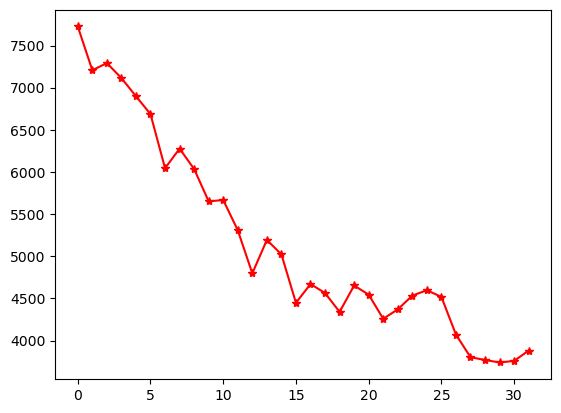

In [37]:
import matplotlib.pyplot as plt

# Move tensors to CPU and convert to NumPy arrays
loss_np = np.array([x.cpu().detach().numpy() for x in loss_lst])

# Plot the NumPy array
plt.plot(loss_np, marker='*', color='r')
plt.show()

In [38]:
test_img=['000002.png']
test_label=['000002.txt']

In [39]:
img_label_folder_path

['dataset/data_object_image_2/training/image_2/', 'dataset/training/label_2/']

In [40]:
testset=CustomDataset(img_label_folder_path,test_img,test_label)
testloader = DataLoader(testset, batch_size=1)

In [41]:
testloader

In [42]:
model.eval()

for _,test_samples in enumerate(testloader):
  test_x,test_y=test_samples
  
  test_pred=model(test_x).permute(0, 2, 3, 1)
  print(test_pred.shape)

YOLO_output=test_pred[0].cpu().detach().numpy()
print(YOLO_output.shape)

torch.Size([1, 13, 13, 70])
(13, 13, 70)


In [43]:
bbox_list = []

In [44]:
ClassesinDataSet=['Car', 'Van', 'Truck','Pedestrian', 'Person_sitting', 'Cyclist', 'Tram','Misc']

In [45]:
def process_bbox(x, y, bbox, classes_score, Classes_inDataSet,dist) : 
    # # size 처리
    bbox_x = bbox[0]
    bbox_y = bbox[1]
    bbox_w = bbox[2]
    bbox_h = bbox[3]
    
    min_x = int(bbox_x - bbox_w/2)
    min_y = int(bbox_y - bbox_h/2)
    max_x = int(bbox_x + bbox_w/2)
    max_y = int(bbox_y + bbox_h/2)
    
    idx_class_highest_score = np.argmax(classes_score)
    class_highest_score = classes_score[idx_class_highest_score] # 가장 높은 class score
    class_highest_score_name = Classes_inDataSet[idx_class_highest_score] # 가장 높은 score를 가진 class의 이름
    
    output_bbox = [min_x, min_y, max_x, max_y, class_highest_score, class_highest_score_name,dist]

    return output_bbox # [x, y, w, h, class_highest_score, class_highest_score_name,dist]로 구성된 list출력
    

In [46]:
for y in range(0, 13) :
  for x in range(0, 13) :
    # bbox에 있는 20개의 클래스 스코어
    bbox1_class_score = YOLO_output[y][x][:8] * YOLO_output[y][x][8]      #class * conf
    bbox2_class_score = YOLO_output[y][x][:8] * YOLO_output[y][x][13]
    bbox3_class_score = YOLO_output[y][x][:8] * YOLO_output[y][x][18]      #class * conf
    bbox4_class_score = YOLO_output[y][x][:8] * YOLO_output[y][x][23]
    bbox5_class_score = YOLO_output[y][x][:8] * YOLO_output[y][x][28]
        
    # bbox의 사이즈
    bbox1 = YOLO_output[y][x][9:13]
    bbox2 = YOLO_output[y][x][14:18]
    bbox3 = YOLO_output[y][x][19:23]
    bbox4 = YOLO_output[y][x][24:28]
    bbox5 = YOLO_output[y][x][29:33]
    dist= YOLO_output[y][x][33] 
    # 24 -> 6(box info + 가장 높게 나온 클래스 prob + 가장 높게 나온 클래스의 idx)개로 처리
    # opencv는 min_x, min_y, max_x, max_y를 원하니 x, y, w, h를 min, max 좌표로 변환
    process_bbox1 = process_bbox(x, y, bbox1,  bbox1_class_score, ClassesinDataSet,dist)
    process_bbox2 = process_bbox(x, y, bbox2,  bbox2_class_score, ClassesinDataSet,dist)
    process_bbox3 = process_bbox(x, y, bbox3,  bbox3_class_score, ClassesinDataSet,dist)
    process_bbox4 = process_bbox(x, y, bbox4,  bbox4_class_score, ClassesinDataSet,dist)
    process_bbox5 = process_bbox(x, y, bbox5,  bbox5_class_score, ClassesinDataSet,dist)
            
    bbox_list.append(process_bbox1)
    bbox_list.append(process_bbox2)
    bbox_list.append(process_bbox3)
    bbox_list.append(process_bbox4)
    bbox_list.append(process_bbox5)

In [47]:
def nms(bbox_list) : 
    nms_bbox_list = []
    for i in range(0, len(bbox_list)) :
        
        if bbox_list[i][4] > 0.02 : # class score가 0.2넘기는 것만 출력하기
            nms_bbox_list.append(bbox_list[i])
    
    return nms_bbox_list

In [48]:
nms_lst=nms(bbox_list)
# bbox_list[1]

In [57]:
for idx in range(len(nms_lst)):
    if nms_lst[idx][4]>15:
        print(nms_lst[idx])

[-293, -59, -331, -80, 15.644558, 'Car', -43.687668]


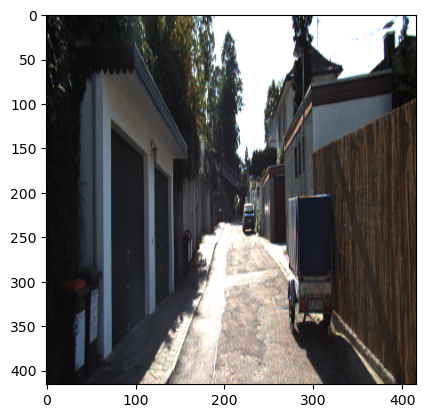

In [50]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(test_x[0].permute(1,2,0).cpu().detach().numpy())
plt.show()